<a href="https://www.kaggle.com/code/kuntalpal/xgboost-baseline-bayesian-optimization?scriptVersionId=113246949" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
!pip install protlearn
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 3.4 MB/s eta 0:00:00
/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv
/kaggle/input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb
/kaggle/input/novozymes-enzyme-stability-prediction/train.csv
/kaggle/input/novozymes-enzyme-stability-prediction/test.csv
/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv


In [2]:
import matplotlib.pyplot as plt
import xgboost as xgb
from matplotlib import rcParams
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import skopt
# Scipy's implementation of Spearman's Rho 
from scipy.stats import spearmanr

from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
seed = 42


In [3]:
df_train = pd.read_csv('../input/novozymes-enzyme-stability-prediction/train.csv')
df_test = pd.read_csv("../input/novozymes-enzyme-stability-prediction/test.csv")
sample = pd.read_csv('../input/novozymes-enzyme-stability-prediction/sample_submission.csv')

print(f"train_shape:{df_train.shape},test_shape:{df_test.shape},Sample_shape:{sample.shape}")

train_shape:(31390, 5),test_shape:(2413, 4),Sample_shape:(2413, 2)


In [4]:
# Make corrections to data 2409 rows, with all features marked as NaN), 
# as well as the rows where the pH and tm were transposed 
# (25 rows, with corrected features in this dataset)

import pandas as pd

df_train_updates = pd.read_csv("../input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv", index_col="seq_id")

all_features_nan = df_train_updates.isnull().all("columns")

drop_indices = df_train_updates[all_features_nan].index
df_train = df_train.drop(index=drop_indices)

swap_ph_tm_indices = df_train_updates[~all_features_nan].index
df_train.loc[swap_ph_tm_indices, ["pH", "tm"]] = df_train_updates.loc[swap_ph_tm_indices, ["pH", "tm"]]

In [5]:
df_train.info()
display(df_train.head(3))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28981 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            28981 non-null  int64  
 1   protein_sequence  28981 non-null  object 
 2   pH                28695 non-null  float64
 3   data_source       28001 non-null  object 
 4   tm                28981 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.3+ MB


,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5


## Physio-Chemical-derived Features

I will use the Protlearn software [link](https://protlearn.readthedocs.io/en/latest/) to extract 21 Physio-Chemical-derived features from the provided protein sequences, as following:

- **Length**: The number of amino acids that a protein is comprised of.
- **Shannon entropy (entropy)**: Computes Shannon entropy for each sequence in the dataset.
- **Amino Acid Composition (AAC)**: The frequency of amino acids for each sequence in the dataset

- **Atomic and bond composition (ATC)**: calculates the sum of atomic and bond compositions for each amino acid sequence. Specifically, atomic features are comprised of five atoms: C, H, N, O, and S; and the bond features are comprised of the following: total bonds, single bonds, and double bonds.


In [6]:
import protlearn as pl
from protlearn.features import length, entropy, aaindex1, atc, aac, ctd

def df_write(keys,values):
    sample_dict = dict()
    dict_keys = keys
    for i in range(len(dict_keys)):
        sample_dict[dict_keys[i]] = [v[i] for v in values]
        
    return pd.DataFrame(sample_dict)

df_feat = pd.DataFrame()
df_feat['length'] = [i[0] for i in length(df_train['protein_sequence'].tolist())]
df_feat['entropy'] = [e[0] for e in entropy(df_train['protein_sequence'].tolist())]

atoms, bonds = atc(df_train['protein_sequence'].tolist())
comp, aa = aac(df_train['protein_sequence'].tolist())
ctd_arr, ctd_desc = ctd(df_train['protein_sequence'].tolist())

# Create the dataframes for training
df_comp = df_write([*aa],comp)
df_atoms = df_write(['Carbon','Hydrogen','Nitrogen','Oxygen','Sulphur'],atoms)
df_bonds = df_write(['total_bonds','single','double'],bonds)
df_dipole = df_write([*ctd_desc],ctd_arr)

# Create the dataframes for testing
df_feat_test = pd.DataFrame()
df_feat_test['length'] = [i[0] for i in length(df_test['protein_sequence'].tolist())]
df_feat_test['entropy'] = [e[0] for e in entropy(df_test['protein_sequence'].tolist())]


atoms_test, bonds_test = atc(df_test['protein_sequence'].tolist())
comp_test, aa_test = aac(df_test['protein_sequence'].tolist())
ctd_arr_test, ctd_desc_test = ctd(df_test['protein_sequence'].tolist())

df_comp_test = df_write([*aa_test],comp_test)
df_atoms_test = df_write(['Carbon','Hydrogen','Nitrogen','Oxygen','Sulphur'],atoms_test)
df_bonds_test = df_write(['total_bonds','single','double'],bonds_test)
df_dipole_test = df_write([*ctd_desc_test],ctd_arr_test)


# Merge the dataframe to create the training dataset 
X_train = pd.concat([df_comp, df_atoms,df_bonds, df_feat, df_dipole], axis=1)
print(X_train.shape)
Y_train = df_train['tm']

# Merge the dataframe to create the test dataset 
X_test = pd.concat([df_comp_test, df_atoms_test, df_bonds_test, df_feat_test, df_dipole_test], axis=1)


(28981, 373)


## Spearman's rank correlation coefficient <a id="3"></a>

[Spearman's Rho](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) is one of the most popular ways to evaluate the correlation between variables. It is an appropriate metric for both continuous and discrete ordinal variables. The Spearman's Rho score will always be between -1 (perfect negative correlation) and 1 (Perfect correlation). 

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/a8dda555d22080d721679401fa13181cad3863f6) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START alpha=2, colsample_bylevel=0.7304484857455519, colsample_bytree=0.966433999423917, gamma=1.647418008086539, lambda=17, learning_rate=0.0673344419215237, max_delta_step=4, max_depth=6, min_child_weight=30, n_estimators=522, subsample=0.7749819709048921
[CV 1/5; 1/1] END alpha=2, colsample_bylevel=0.7304484857455519, colsample_bytree=0.966433999423917, gamma=1.647418008086539, lambda=17, learning_rate=0.0673344419215237, max_delta_step=4, max_depth=6, min_child_weight=30, n_estimators=522, subsample=0.7749819709048921;, score=-59.367 total time=  18.9s
[CV 2/5; 1/1] START alpha=2, colsample_bylevel=0.7304484857455519, colsample_bytree=0.966433999423917, gamma=1.647418008086539, lambda=17, learning_rate=0.0673344419215237, max_delta_step=4, max_depth=6, min_child_weight=30, n_estimators=522, subsample=0.7749819709048921
[CV 2/5; 1/1] END alpha=2, colsample_bylevel=0.7304484857455519, colsample_bytree=0.96643399

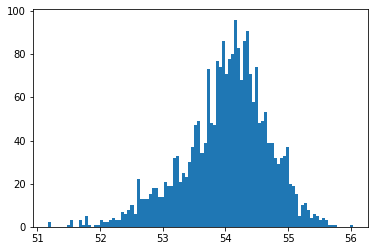

In [8]:
import xgboost as xgb
# Scipy's implementation of Spearman's Rho 
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split

def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')




def spearmans_rho(y_pred, y_true):
    """
        Calculates the Spearman's Rho Correlation between ground truth labels and predictions 
    """
    rho, pvalue = spearmanr(y_true, y_pred)
    return rho


bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBRegressor(
        n_jobs = -1,
        objective = 'reg:squarederror',
        eval_metric = 'mae',
        tree_method='hist',
        #gpu_id = 0
    ),

search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'max_depth': (2, 7,'uniform'),
        'max_delta_step': (0, 10,'uniform'),
        'subsample': (0.5, 1.0, 'uniform'),
        'colsample_bytree': (0.5, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'gamma' : (0.1,5.0, 'uniform'),
        'lambda': (2, 50, 'log-uniform'),
        'alpha': (0, 4.0, 'uniform'),
        'min_child_weight': (0, 100),
        'n_estimators': (10, 25),
    },    
scoring = 'neg_mean_squared_error',
    cv = KFold(
        n_splits=5,
        shuffle=True,
        random_state=seed
    ),
    n_iter = 100,
    verbose = 20,
    refit = True,
    random_state = seed
)

bayes_cv_tuner.fit(X_train, Y_train)
best_params = bayes_cv_tuner.best_params_

display(bayes_cv_tuner)
gb_clf = xgb.XGBRegressor(**best_params,random_state=seed).fit(X_train,Y_train)
test_pre = gb_clf.predict(X_test)

plt.hist(test_pre, bins=50)
plt.show()

In [ ]:
sample.tm = test_pre
sample.to_csv("submission.csv",index=False)
print("successfully create first baseline work!")